# Fine-tuned YAMNet: small aircraft detection

In [1]:
import pyaudio, librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Decide what type of messages are displayed by TensorFlow (ERROR, WARN, INFO, DEBUG, FATAL)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Disable eager execution for TF1 compatibility
tf.compat.v1.disable_eager_execution()

In [2]:
# TensorFlow memory allocation options:
# # OPTION 1: "smart" allocation
# config=tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess=tf.Session(config=config) 

# OPTION 2: maximum memory allocation per session (0-1 = 0-100%)
tf_ver = tf.__version__
if tf_ver[0] == "1":
    gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
elif tf_ver[0] == "2":
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.05)
    sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# OPTION 3: ???
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# OPTION 4: ???
#Slim/embedded versions: (https://github.com/google-research/tf-slim)

print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)

tf version:  2.2.0
tf.keras version:  2.3.0-tf


In [3]:
# Add/append required paths
import os, sys

path_root = '/home/anakin/Models/yamnet_planes/' #path to main folder
# path_root = input("Enter the path of your repository: ") # ask user for path_root
assert os.path.exists(path_root)
sys.path.append(path_root)

path_yamnet_original = path_root+'yamnet_original/' #path to original yamnet files
assert os.path.exists(path_yamnet_original)
# sys.path.append(path_yamnet_original)

In [4]:
# Load functions
%run "yamnet_functions.py"

## YAMNet (original) predictions on a single audio

In [5]:
import yamnet_original.features as features
import yamnet_original.params as params
import yamnet_original.yamnet as yamnet

class_names = yamnet.class_names(path_yamnet_original+'yamnet_class_map.csv')

params.PATCH_HOP_SECONDS = 0.96 #low values: higher accuracy but higher computational cost

yamnet_vis = yamnet.yamnet_frames_model(params)
yamnet_vis.load_weights(path_root+'yamnet.h5')

In [153]:
# Understand impact of parameters on input image and visualise
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

# Load waveform-
file_name = "/home/anakin/Datasets/airplanes_v0/training_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=True)
DESIRED_DURATION = 3.84 #[s]
waveform = waveform[0:round(DESIRED_DURATION*DESIRED_SR)] #the last data point does not need to be included in the STFT

print('Waveform size:', waveform.shape, 'and duration:', waveform.shape[0]/DESIRED_SR, '[s]\n')

# Calculate spectrogram
log_mel_spectrogram, magnitude_spectrogram, spectrogram = features.waveform_to_log_mel_spectrogram(waveform,params,print_on=1)

spectrogram = spectrogram.eval(session=sess)
magnitude_spectrogram = magnitude_spectrogram.eval(session=sess)
log_mel_spectrogram = log_mel_spectrogram.eval(session=sess)

print('Spectrogram (complex) size (x,y):',spectrogram.shape)
print('Spectrogram (magnitude) size (x,y):',magnitude_spectrogram.shape)
print('Log-scaled mel spectrogram size (x,y):',log_mel_spectrogram.shape,'\n')

# Calculate features (patches)
features_img = features.spectrogram_to_patches(log_mel_spectrogram, params, print_on=1)
features_img = features_img.eval(session=sess)

# Calculate scores
scores, _, _ = yamnet_vis.predict(np.reshape(waveform, [1, -1]), steps=1)

print('Features size (images,x,y):',features_img.shape)
print('Scores size (images,classes):',scores.shape)

Waveform size: (61440,) and duration: 3.84 [s]

SPECTROGRAM PARAMETERS:
stft_frame_length: 400
stft_frame_step: 160
fft_length: 512
fft_frequency_bins: 257 

Spectrogram (complex) size (x,y): (384, 257)
Spectrogram (magnitude) size (x,y): (384, 257)
Log-scaled mel spectrogram size (x,y): (384, 64) 

feature_frame_length: 96
feature_frame_step: 96 

Features size (images,x,y): (4, 96, 64)
Scores size (images,classes): (4, 521)


In [125]:
feature_frame_step = int(round(params.PATCH_HOP_SECONDS/params.STFT_HOP_SECONDS))
print(feature_frame_step)
log_mel_spectrogram.shape[0]/feature_frame_step

96


1.0104166666666667

In [ ]:
file_tmp = "/home/anakin/tmp_audio.wav"
play_audio(file_tmp,DESIRED_SR,waveform)

[-0.48, 3.36]
[-0.48, 3.36]


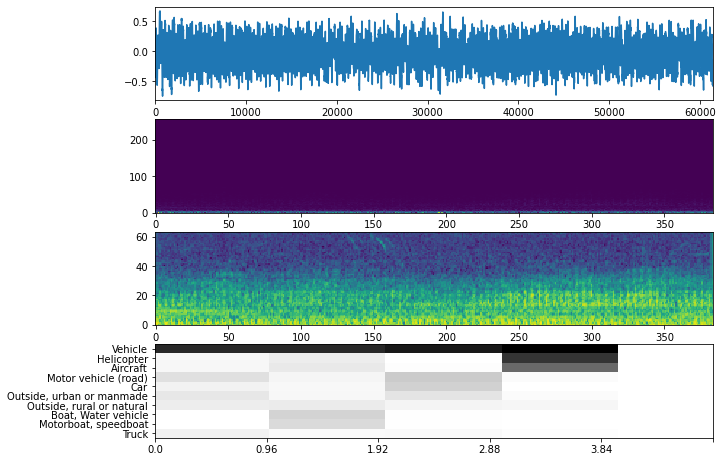

In [154]:
# Visualize the results
plt.figure(figsize=(10, 10))

# Plot the waveform
plt.subplot(5, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the magnitude spectrogram
plt.subplot(5, 1, 2)
plt.imshow(magnitude_spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot the log-scaled mel spectrogram
plt.subplot(5, 1, 3)
plt.imshow(log_mel_spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes for each 
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(5, 1, 4)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_HOP_SECONDS to align with log-scaled mel spectrogram

#NOTE: continue here, as xlim_values is still not exactly right
xlim_values = [-params.PATCH_HOP_SECONDS/2, -params.PATCH_HOP_SECONDS/2 + (log_mel_spectrogram.shape[0]/feature_frame_step)*params.PATCH_HOP_SECONDS]
plt.xlim(xlim_values)

print(xlim_values)

xticks_values = [-params.PATCH_HOP_SECONDS/2, -params.PATCH_HOP_SECONDS/2 + scores.shape[0]*params.PATCH_HOP_SECONDS]
plt.xticks(np.arange(xticks_values[0], xticks_values[1] + params.PATCH_HOP_SECONDS, step=params.PATCH_HOP_SECONDS), np.arange(0, (scores.shape[0]+1)*params.PATCH_HOP_SECONDS, step=params.PATCH_HOP_SECONDS))
print(xticks_values)

# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

## Data augmentation
Random data augmentation is performed on the original waveforms. A feature vector is generated for every waveform which will later be used to train a fully-connected classifier. 


In [ ]:
# Modified YAMNet model for feature extraction
import yamnet_original.params as params
import yamnet_modified as yamnet_modified

params.PATCH_HOP_SECONDS = 0.96 #low values: higher accuracy but higher computational cost

yamnet_features = yamnet_modified.yamnet_frames_model(params)
yamnet_features.load_weights(path_root+'yamnet.h5')

In [ ]:
DESIRED_SR = params.SAMPLE_RATE # required by YAMNet

samples, labels = load_data("/home/anakin/Datasets/airplanes_v0/training_data/",
    yamnet_features,
    num_augmentations=2,
    max_sample_seconds=5.0,
    DESIRED_SR=DESIRED_SR)

In [ ]:
print(labels)

In [ ]:
# Randomise sample/label order
import random

idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


## Train a classifier using YAMNet's feature vector as input

In [ ]:
# Classifier definition
from tensorflow.keras import Model, layers

def yamnet_classifier(input_size=1024,
    num_hidden=1024,
    num_classes=2):
    
    input_layer = layers.Input(shape=(input_size,)) #takes a vector of size (input_size,)
    dense_layer = layers.Dense(num_hidden, activation=None)(input_layer) #classifier layer with (num_hidden) neurons
    classifier_layer = layers.Dense(num_classes, activation='softmax')(dense_layer) #activation layer with (num_classes) neurons
    model = Model(inputs=input_layer, outputs=classifier_layer)
    return model

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

features_img_length = 1024
num_hidden = 1024
num_classes = 2

yamnet_planes = yamnet_classifier(
    input_size=features_img_length, 
    num_hidden=num_hidden,
    num_classes=num_classes)

# Optimisation configuration
#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the classifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
save_best = ModelCheckpoint('top_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = yamnet_planes.fit(samples, labels, epochs=200, validation_split=0.1)
# history = yamnet_planes.fit(samples, labels, epochs=200, validation_split=0.1, callbacks=[save_best])

## Test on holdout sounds

In [ ]:
# Load model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam

yamnet_planes = load_model(path_root+'top_model_v2.h5')
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
yamnet_planes.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
yamnet_planes.summary()

In [ ]:
## Specify class labels
class_labels = ["not plane", "plane"]

In [ ]:
# Scores for a single holdout audio
file_name = "/home/anakin/Datasets/airplanes_v2/holdout_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)

scores = run_models(waveform, yamnet_features, yamnet_planes)
winner = class_labels[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))

In [ ]:
# Scores for a holdout folder
holdout_dir = "/home/anakin/Datasets/airplanes_v2/holdout_data/not_plane/"
arr = os.listdir(holdout_dir)

for fname in arr:
    print(fname)
    fname = holdout_dir+fname
    waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

    # make file a bit longer by duplicating it 
    waveform = np.concatenate((waveform,waveform,waveform))
    scores = run_models(waveform, yamnet_features, yamnet_planes, strip_silence=False)
    winner_save = np.empty((0,2))
    if scores[0] != -1:
        winner = class_labels[scores.argmax()]
        print(" Best score: {}  label: {}".format(scores.max(), winner))
        # winner_save = np.append(winner_save,np.array([scores.max(),winner]),axis=0)

In [ ]:
# result_array = np.empty((0, 2))
# result = np.array([1,"a"])
# result_array = np.append(result_array, [result], axis=0)
# result_array = np.append(result_array, [result], axis=0)

# result_array

In [ ]:
## Save the model for later
model.save("top_model_v3.h5", include_optimizer=False)